<a href="https://colab.research.google.com/github/krakenalt/LIsa-Traffic-Signs/blob/main/%D0%9F%D0%A0%D0%9E%D0%95%D0%9A%D0%A2_%D0%9C%D0%90%D0%A8%D0%98%D0%9D%D0%9A%D0%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!wget http://cvrr.ucsd.edu/LISA/Datasets/signDatabasePublicFramesOnly.zip

In [ ]:
#!unzip "/content/signDatabasePublicFramesOnly.zip" -d "/content/drive/MyDrive/ПРОЕКТ_МАШИНКА"

In [ ]:
!pip install pytorch-lightning
!pip install albumentations==0.4.6
!pip install lightning-bolts

     |████████████████████████████████| 808kB 7.7MB/s 
     |████████████████████████████████| 112kB 26.1MB/s 
     |████████████████████████████████| 645kB 16.5MB/s 
     |████████████████████████████████| 829kB 34.9MB/s 
     |████████████████████████████████| 276kB 37.8MB/s 
     |████████████████████████████████| 10.6MB 38.2MB/s 
     |████████████████████████████████| 1.3MB 32.2MB/s 
     |████████████████████████████████| 296kB 37.4MB/s 
     |████████████████████████████████| 143kB 32.2MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=5ff23d617e34ba65509943c6e9efa6c7a93453611bec54dbee17a48eb3abaa77
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uni

In [ ]:
import glob
import os
import random
from time import time

import albumentations
import albumentations as A
import cv2
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
from PIL import Image
from albumentations.pytorch import ToTensorV2
from google.colab import drive, files
from google.colab.patches import cv2_imshow
from pl_bolts.models.detection.faster_rcnn import FasterRCNN
from pylab import rcParams
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SequentialSampler
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import box_iou, nms
from tqdm import tqdm
from tqdm.notebook import tqdm

In [ ]:
torch.cuda.empty_cache() 
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SUBFOLDERS = os.listdir("/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/")
SUBFOLDERS

['videoSources.txt',
 'categories.txt',
 'allAnnotations.csv',
 'datasetDescription.pdf',
 'readme.txt',
 'tools',
 'vid0',
 'vid1',
 'vid11',
 'vid10',
 'vid2',
 'vid3',
 'vid4',
 'vid5',
 'vid6',
 'vid8',
 'vid7',
 'vid9',
 'aiua120214-0',
 'aiua120214-1',
 'aiua120214-2',
 'aiua120306-0',
 'aiua120306-1',
 'negatives',
 'BEST_MODEL.ckpt',
 'WORKING_MODEL.ckpt']

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/'

In [ ]:
df = pd.read_csv(DATA_PATH + "allAnnotations.csv", sep=";")
df

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,"Occluded,On another road",Origin file,Origin frame number,Origin track,Origin track frame number
0,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,862,104,916,158,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
1,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimitUrdbl,425,197,438,213,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
2,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,922,88,982,148,"1,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
3,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,447,193,461,210,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
4,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,469,189,483,207,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2677,stop_1330545910.avi,12
...,...,...,...,...,...,...,...,...,...,...,...
7850,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,41,209,65,239,"0,0",vid9/MVI_0121.MOV,8813,speedLimit_1324866802.avi,22
7851,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,526,213,543,233,"0,0",vid9/MVI_0121.MOV,8875,speedLimit_1324866807.avi,2
7852,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,546,208,564,230,"0,0",vid9/MVI_0121.MOV,8880,speedLimit_1324866807.avi,7
7853,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,573,204,592,228,"0,0",vid9/MVI_0121.MOV,8885,speedLimit_1324866807.avi,12


In [ ]:
df = df.drop(['Origin track','Origin track','Origin track frame number',"Occluded,On another road","Origin frame number","Origin file"],axis=1)
df

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y
0,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,862,104,916,158
1,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimitUrdbl,425,197,438,213
2,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,922,88,982,148
3,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,447,193,461,210
4,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,469,189,483,207
...,...,...,...,...,...,...
7850,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,41,209,65,239
7851,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,526,213,543,233
7852,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,546,208,564,230
7853,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,573,204,592,228


In [ ]:
df.columns = ["image_id","label","x_min","y_min","x_max","y_max"]

In [ ]:
def change_id(x):
  name = x.image_id
  return os.path.join(DATA_PATH,f'{name}')


df["image_id"] = df.apply(change_id,axis=1)
df

,image_id,label,x_min,y_min,x_max,y_max
0,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/aiua1202...,stop,862,104,916,158
1,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/aiua1202...,speedLimitUrdbl,425,197,438,213
2,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/aiua1202...,stop,922,88,982,148
3,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/aiua1202...,speedLimit25,447,193,461,210
4,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/aiua1202...,speedLimit25,469,189,483,207
...,...,...,...,...,...,...
7850,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/vid9/fra...,speedLimit35,41,209,65,239
7851,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/vid9/fra...,speedLimit35,526,213,543,233
7852,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/vid9/fra...,speedLimit35,546,208,564,230
7853,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/vid9/fra...,speedLimit35,573,204,592,228


In [ ]:
df.label.unique()

array(['stop', 'speedLimitUrdbl', 'speedLimit25', 'pedestrianCrossing',
       'speedLimit35', 'turnLeft', 'slow', 'speedLimit15', 'speedLimit45',
       'rightLaneMustTurn', 'signalAhead', 'keepRight', 'laneEnds',
       'school', 'merge', 'addedLane', 'rampSpeedAdvisory40',
       'rampSpeedAdvisory45', 'curveRight', 'speedLimit65',
       'truckSpeedLimit55', 'thruMergeLeft', 'speedLimit30', 'stopAhead',
       'yield', 'thruMergeRight', 'dip', 'schoolSpeedLimit25',
       'thruTrafficMergeLeft', 'noRightTurn', 'rampSpeedAdvisory35',
       'curveLeft', 'rampSpeedAdvisory20', 'noLeftTurn', 'zoneAhead25',
       'zoneAhead45', 'doNotEnter', 'yieldAhead', 'roundabout',
       'turnRight', 'speedLimit50', 'rampSpeedAdvisoryUrdbl',
       'rampSpeedAdvisory50', 'speedLimit40', 'speedLimit55', 'doNotPass',
       'intersection'], dtype=object)

In [ ]:
len(df.label.unique())

47

In [ ]:
df.label.value_counts()

stop                      1821
pedestrianCrossing        1085
signalAhead                925
speedLimit35               538
speedLimit25               349
keepRight                  331
addedLane                  294
merge                      266
yield                      236
laneEnds                   210
stopAhead                  168
speedLimit45               141
speedLimit30               140
school                     133
speedLimitUrdbl            132
schoolSpeedLimit25         105
turnRight                   92
rightLaneMustTurn           77
speedLimit65                74
speedLimit40                73
truckSpeedLimit55           60
yieldAhead                  57
roundabout                  53
curveRight                  50
speedLimit50                48
noLeftTurn                  47
curveLeft                   37
dip                         35
slow                        34
turnLeft                    32
rampSpeedAdvisory45         29
noRightTurn                 26
doNotEnt

In [ ]:
le = LabelEncoder()
idx = le.fit_transform(df.label.unique())
label_to_idx = dict(zip(df.label.unique(),idx))
idx_to_label = dict(zip(idx,label_to_idx))
df['label'] = df[['label']].applymap(lambda s: label_to_idx.get(s) if s in label_to_idx else s)
df

,image_id,label,x_min,y_min,x_max,y_max
0,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/aiua1202...,35,862,104,916,158
1,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/aiua1202...,34,425,197,438,213
2,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/aiua1202...,35,922,88,982,148
3,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/aiua1202...,26,447,193,461,210
4,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/aiua1202...,26,469,189,483,207
...,...,...,...,...,...,...
7850,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/vid9/fra...,28,41,209,65,239
7851,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/vid9/fra...,28,526,213,543,233
7852,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/vid9/fra...,28,546,208,564,230
7853,/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/vid9/fra...,28,573,204,592,228


stop


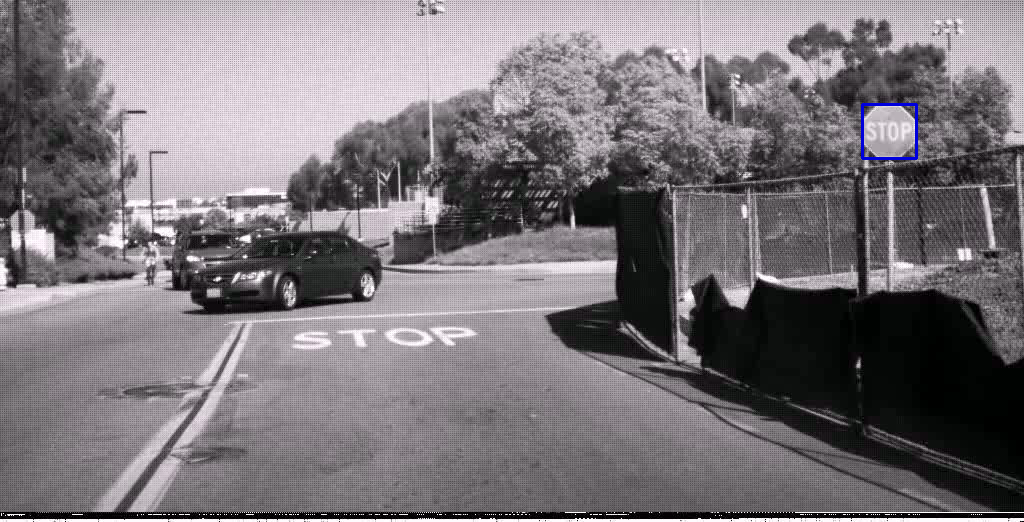

speedLimitUrdbl


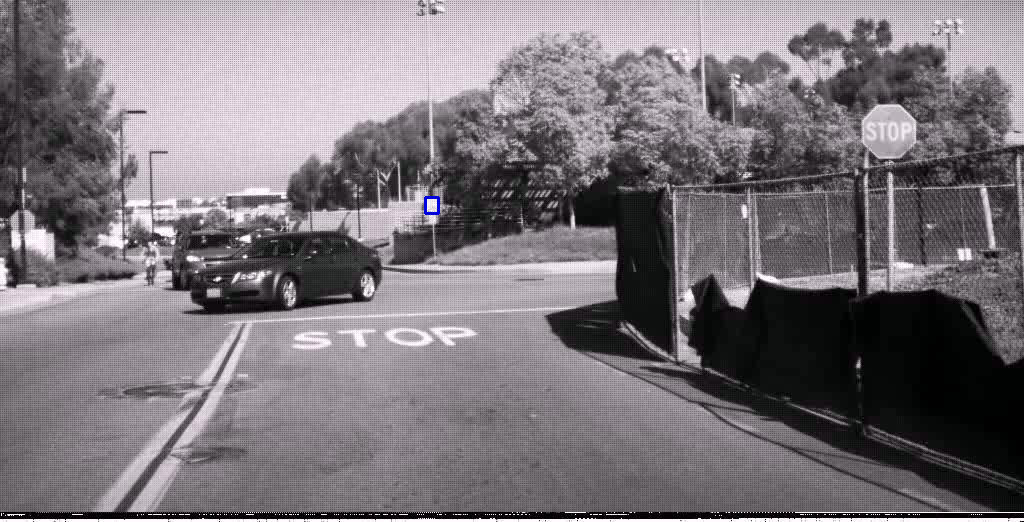

stop


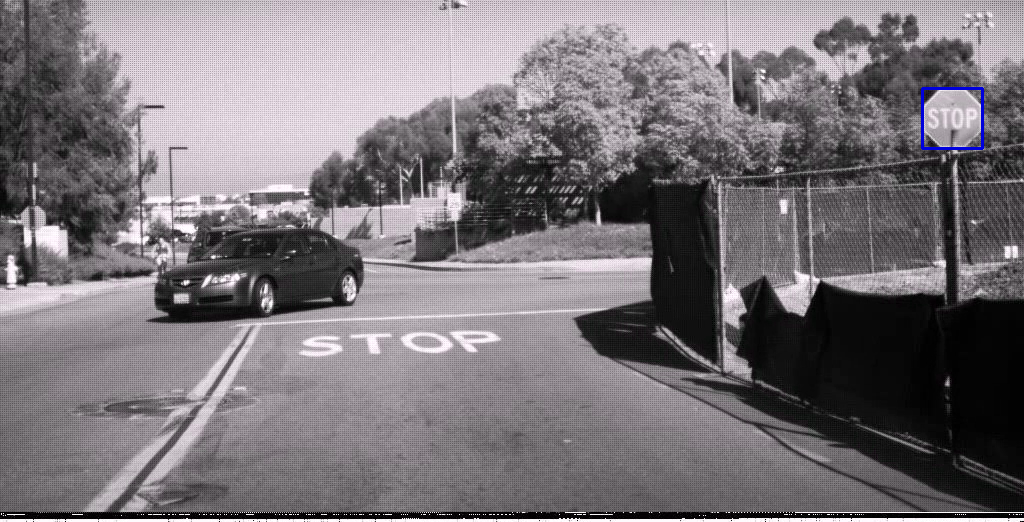

In [ ]:
for i in range(3):
  input = df.loc[i]
  img = cv2.imread(input[0])
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  label = input[1]
  bbox = [input[2],input[3],input[4],input[5]]
  cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (220,0,0), 2)
  print(idx_to_label[label])
  cv2_imshow(img)

In [ ]:
class CustomDataset:
    def __init__(self, df,transforms=None):
        super().__init__()

        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return self.image_ids.shape[0]

    def __getitem__(self, index):

        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.as_tensor(records.label.values, dtype=torch.int64)
        
        iscrowd = torch.zeros_like(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])
            
        return image, target

In [ ]:
def getTrainTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
dataset = CustomDataset(df,transforms=getTrainTransform())

In [ ]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
val_split = .2
split = int(np.floor(val_split * dataset_size))

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, 
                                           sampler=train_sampler,collate_fn=collate_fn,pin_memory=True)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=8,
                                                sampler=valid_sampler,collate_fn=collate_fn)

In [ ]:
images, targets = next(iter(train_loader))

boxes = targets[1]['boxes'].numpy().astype(np.int32)
image = images[1].permute(1,2,0).numpy()
target = targets[1]["labels"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


stop


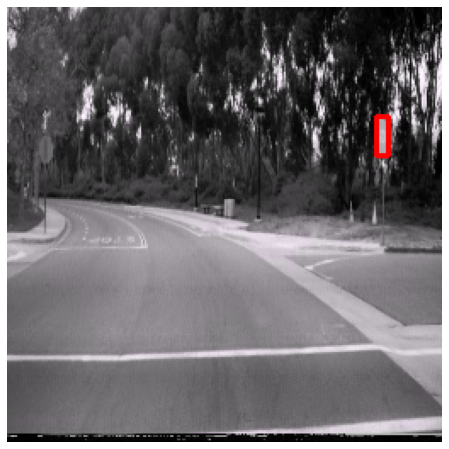

In [ ]:
def displayImage(image, boxes,target=None):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
      start_point = (box[0], box[1])
      end_point = (box[2], box[3])
      color = (255,0,0)
      thickness = 2
      cv2.rectangle(image, start_point, end_point,color,thickness)

    ax.set_axis_off()
    image = np.array(image.squeeze())
    ax.imshow(image)
    if target is not None:
      for element in target:
        print(idx_to_label[element.item()])

    plt.show()

displayImage(image,boxes,target)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
def _evaluate_iou(target, pred):
    """
    Evaluate intersection over union (IOU) for target from dataset and output prediction
    from model
    """
    if pred["boxes"].shape[0] == 0:
        # no box detected, 0 IOU
        return torch.tensor(0.0, device=pred["boxes"].device)
    return box_iou(target["boxes"], pred["boxes"]).diag().mean()

class LoggingRCNN(FasterRCNN):
  def validation_step(self, batch, batch_idx):
        images, targets = batch
        outs = self.model(images)
        iou = torch.stack([_evaluate_iou(t, o) for t, o in zip(targets, outs)]).mean()
        self.log('val_iou', iou)
        return {"val_iou": iou}

In [ ]:
N_CLASS = 47
model = LoggingRCNN(lr = 1e-1, num_classes=N_CLASS,pretrained=True)
model.to(device)

LoggingRCNN(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (b

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou',
    dirpath='/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/',
    filename='BEST_MODEL'
)
early_stopping_callback = EarlyStopping(monitor='val_iou')

trainer = pl.Trainer(callbacks=[early_stopping_callback, checkpoint_callback], gpus=1)
trainer.fit(model, train_loader, validation_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.5 M
-------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.119   Total estimated model params size (MB)


In [ ]:
trainer.validate(model,validation_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_iou': 0.5111823678016663}
--------------------------------------------------------------------------------


[{'val_iou': 0.5111823678016663}]

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ПРОЕКТ_МАШИНКА/WORKING_MODEL.ckpt')

In [ ]:
model = LoggingRCNN(lr = 1e-1, num_classes=N_CLASS,pretrained=True)
model.load_state_dict(torch.load(DATA_PATH + "WORKING_MODEL.ckpt"))
model

In [ ]:
def filterBoxes(output,nms_th=0.2,score_threshold=0.2):
    
    boxes = output['boxes']
    scores = output['scores']
    labels = output['labels']
    
    mask = nms(boxes,scores,nms_th)
    
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    
    mask = scores >= score_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return boxes, scores, labels

In [ ]:
def displayPredictions(image,output,target, nms_th=0.2,score_threshold=0.2):
    
    boxes,scores,labels = filterBoxes(output,nms_th,score_threshold)
    true_labels = target["labels"].numpy()
    true_boxes = target["boxes"].numpy()
    image = np.transpose(image.numpy(),(1,2,0))
    #print(true_boxes)
    pred_color = (255,0,0) #color for prediction box
    true_color = (0,0,255)# real box
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box,label in zip(boxes,labels):
        image = cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]), pred_color,
                      3)
       
    for box, label in zip(true_boxes, true_labels):
      #import pdb
      #pdb.set_trace()
      image = cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]), true_color,
                      2)
    ax.set_axis_off()
    ax.imshow(image)
    print("Predicted: ",[idx_to_label[i] for i in labels])
    print("Real: ", [idx_to_label[i] for i in true_labels])
    print("IOU: ", torchvision.ops.box_iou(torch.Tensor(true_boxes),torch.Tensor(boxes)))

    plt.show()

In [ ]:
images, target = next(iter(validation_loader))

In [ ]:
preds = model(images)

In [ ]:
index = 6
image = images[index]
boxes = target[index]["boxes"]
pred = preds[index]["boxes"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  ['stop']
Real:  ['stopAhead']
IOU:  tensor([[0.5172]])


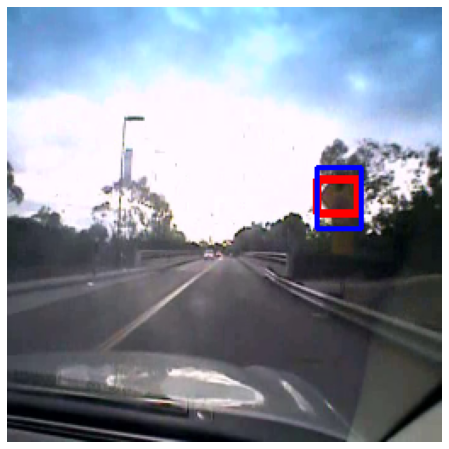

In [ ]:
displayPredictions(image,preds[index],target[index])